# Introduction to Automation with LangChain, Generative AI, and Python
**Lab 4: Add Pictures to Book**
* Instructor: [Jeff Heaton](https://youtube.com/@HeatonResearch), WUSTL Center for Analytics and Business Insight (CABI), [Washington University in St. Louis](https://olin.wustl.edu/faculty-and-research/research-centers/center-for-analytics-and-business-insight/index.php)
* For more information visit the [class website](https://github.com/jeffheaton/cabi_genai_automation).

# Instructions

Recall the book generator that we saw earlier? Lets add a cover picture to the title page. Below is a function that will render an image from the specified prompt and output to a filename. This is the same code that was presented earlier.

In [ ]:
import base64
import io
import json
import os
import sys

import boto3
from PIL import Image
import botocore

def render_diffusion(prompt, filename, height, width):
    boto3_bedrock = boto3.client('bedrock-runtime')
    negative_prompts = [
        "poorly rendered",
        "poor background details",
        "writing",
        "text",
    ]
    style_preset = "photographic"
    clip_guidance_preset = "FAST_GREEN"
    sampler = "K_DPMPP_2S_ANCESTRAL"

    request = json.dumps({
        "text_prompts": (
            [{"text": prompt, "weight": 1.0}]
            + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
        ),
        "cfg_scale": 5,
        "seed": 42,
        "steps": 60,
        "style_preset": style_preset,
        "clip_guidance_preset": clip_guidance_preset,
        "sampler": sampler,
        "width": width,
        "height": height
    })
    modelId = "stability.stable-diffusion-xl-v1"

    response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
    response_body = json.loads(response.get("body").read())

    print(response_body["result"])
    base_64_img_str = response_body["artifacts"][0].get("base64")
    image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
    image.save(filename)
    return image


Provided here is the book code from before. Modify this code to add an image that you generate with the render_diffusion function. Claude 3 can give you the code to add an image to the markdown, but it may not be able to make the complete change. You should also call the LLM to transform the synopsis into an image generation prompt.

In [4]:
# Imports organized by source and purpose
from IPython.display import display_markdown
import markdown
import pdfkit

from langchain import OpenAI, PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.document_loaders import PyPDFLoader, TextLoader
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate
from langchain_aws import ChatBedrock

# Constants used in the program
MODEL = 'anthropic.claude-3-sonnet-20240229-v1:0'
SUBJECT = "international spy story"

# Initialize ChatBedrock with specified model and settings
llm = ChatBedrock(
    model_id=MODEL,
    model_kwargs={"temperature": 0.7}
)

def query_llm(prompt):
    """Query the language model with a formatted prompt and return the response content."""
    messages = [
        SystemMessage(
            content="""You are writing a book, return just what I ask you for. 
                       Do not add comments, it is very important that you only 
                       provide the final output without any additional comments 
                       or remarks. Do not repeat my command or a summary of my command."""
        ),
        HumanMessage(content=prompt)
    ]

    output = llm.invoke(messages)
    return output.content.strip(" '\"")

# Generate book title, synopsis, and table of contents
title = query_llm(f"Give me a random title for a book on the subject '{SUBJECT}'. Return only the title, no additional text.")
print(f"Title: {title}")

synopsis = query_llm(f"Give me just a synopsis for a book of the title '{title}' on the subject '{SUBJECT}'.")
print(f"Synopsis: {synopsis}")


toc = query_llm(f"Give me a table of contents for a book of the title '{title}' on the subject '{SUBJECT}' "
                f"the book synopsis is '{synopsis}'. Return the table of contents as a list of chapter titles. "
                f"Separate the chapter number and chapter title with a pipe character '|'. "
                f"Do not give me any line that is not a chapter!")

# Split the table of contents into lines and extract chapter titles
lines = toc.splitlines()
toc2 = [line.split('|')[1].strip() for line in lines if line]

# Render the book chapters
book = f"# {title}\n{synopsis}\n\n## Table of Contents\n\n" + "\n".join(f"{i+1}. {title}" for i, title in enumerate(toc2))

def render_chapter(num, chapter_title):
    """Generate content for a chapter given the chapter number and title."""
    txt = query_llm(f"Write Chapter {num}, titled '{chapter_title}' for a book of the title '{title}' on "
                    f"the subject '{SUBJECT}' the book synopsis is '{synopsis}' the table of contents is '{toc}'. "
                    f"Give me only the chapter text, no chapter heading, no chapter title, number, no additional text. "
                    f"Make sure the chapter is at least 3,000 to 4,000 words. End with a complete sentence, do not cut off.")
    return txt

# Render the entire book
for chapter_num, chapter_title in enumerate(toc2, start=1):
    print(f"Rendering chapter {chapter_num}/{len(toc2)}: {chapter_title}")
    chapter_text = render_chapter(chapter_num, chapter_title)
    book += f"\n\n## Chapter {chapter_num}: {chapter_title}\n{chapter_text}"

# Convert Markdown to HTML and then to PDF
html = markdown.markdown(book)
pdfkit.from_string(html, 'output.pdf', options={"enable-local-file-access": ""})


Title: Collateral Deception
Synopsis: A high-stakes international spy thriller, 'Collateral Deception' follows the exploits of CIA operative Sarah Knowles as she unravels a web of deceit and betrayal that threatens global security. After a routine mission goes awry, Sarah finds herself embroiled in a deadly conspiracy involving rogue agents, powerful corporations, and a sinister plot that could ignite a new world war. With the fate of nations hanging in the balance, Sarah must navigate a treacherous landscape of lies and double-crosses, relying on her wits and skills to uncover the truth before it's too late.
Rendering chapter 1/13: Prologue: The Calm Before the Storm
Rendering chapter 2/13: Whispers in the Night
Rendering chapter 3/13: Echoes of Betrayal
Rendering chapter 4/13: Shadows in the Boardroom
Rendering chapter 5/13: The Rabbit Hole
Rendering chapter 6/13: Ghosts of the Past
Rendering chapter 7/13: The Moscow Connection
Rendering chapter 8/13: Infiltration
Rendering chapter 9

True

## Solution

In [1]:
import base64
import io
import json
import os
import sys

import boto3
from PIL import Image
import botocore

def render_diffusion(prompt, filename, height, width):
    boto3_bedrock = boto3.client('bedrock-runtime')
    negative_prompts = [
        "poorly rendered",
        "poor background details",
        "poorly drawn mountains",
        "disfigured mountain features",
    ]
    style_preset = "photographic"
    clip_guidance_preset = "FAST_GREEN"
    sampler = "K_DPMPP_2S_ANCESTRAL"

    request = json.dumps({
        "text_prompts": (
            [{"text": prompt, "weight": 1.0}]
            + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
        ),
        "cfg_scale": 5,
        "seed": 42,
        "steps": 60,
        "style_preset": style_preset,
        "clip_guidance_preset": clip_guidance_preset,
        "sampler": sampler,
        "width": width,
        "height": height
    })
    modelId = "stability.stable-diffusion-xl-v1"

    response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
    response_body = json.loads(response.get("body").read())

    print(response_body["result"])
    base_64_img_str = response_body["artifacts"][0].get("base64")
    image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
    image.save(filename)
    return image


Title: Whispers from the Shadows
Synopsis: In the world of espionage, secrets lurk in every shadow. 'Whispers from the Shadows' follows the thrilling journey of a covert operative, tasked with unraveling a vast international conspiracy that threatens global stability. From the bustling streets of London to the remote corners of Moscow, this fast-paced spy novel takes readers on a breathtaking ride filled with intrigue, betrayal, and high-stakes action. As the protagonist navigates a web of deception, they must confront formidable adversaries and confront their own demons, all while racing against time to prevent a catastrophic event that could plunge the world into chaos.
Cover prompt: book cover, espionage thriller novel, spy silhouette with city skyline in background, intrigue, betrayal, secrets, international conspiracy, high-stakes action, dramatic lighting
success


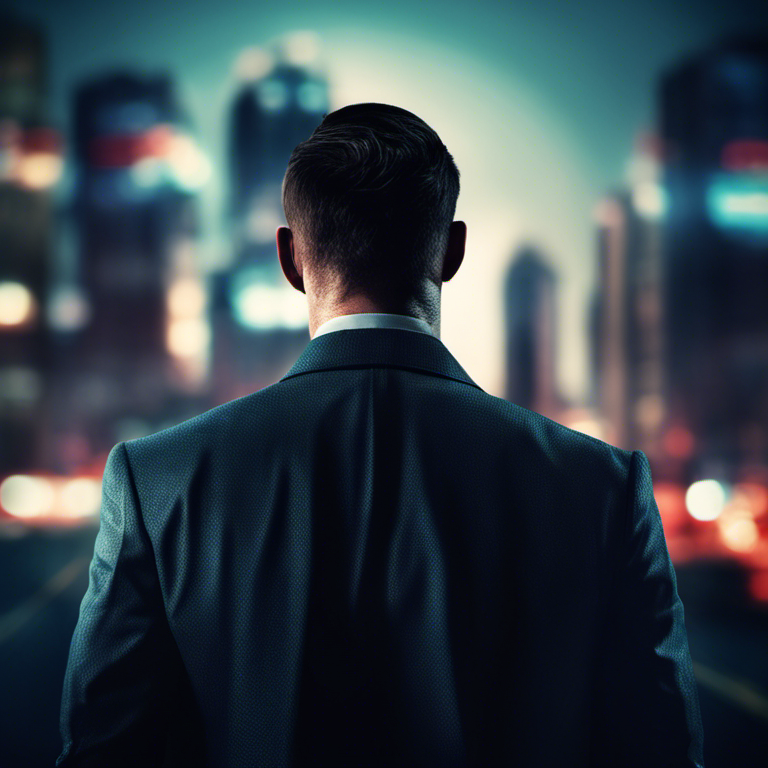

Rendering chapter 1/10: Prologue: Whispers in the Night
Rendering chapter 2/10: Operatives in the Shadows
Rendering chapter 3/10: The London Connection
Rendering chapter 4/10: Echoes from Moscow
Rendering chapter 5/10: Betrayal in Berlin
Rendering chapter 6/10: The Kremlin's Secret
Rendering chapter 7/10: Chasing Ghosts
Rendering chapter 8/10: Unraveling the Conspiracy
Rendering chapter 9/10: The Endgame
Rendering chapter 10/10: Epilogue: A New Dawn


True

In [3]:
# Imports organized by source and purpose
from IPython.display import display_markdown
import markdown
import pdfkit

from langchain import OpenAI, PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.document_loaders import PyPDFLoader, TextLoader
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate
from langchain_aws import ChatBedrock

# Constants used in the program
MODEL = 'anthropic.claude-3-sonnet-20240229-v1:0'
SUBJECT = "international spy story"

# Initialize ChatBedrock with specified model and settings
llm = ChatBedrock(
    model_id=MODEL,
    model_kwargs={"temperature": 0.7}
)

def query_llm(prompt):
    """Query the language model with a formatted prompt and return the response content."""
    messages = [
        SystemMessage(
            content="""You are writing a book, return just what I ask you for. 
                       Do not add comments, it is very important that you only 
                       provide the final output without any additional comments 
                       or remarks. Do not repeat my command or a summary of my command."""
        ),
        HumanMessage(content=prompt)
    ]

    output = llm.invoke(messages)
    return output.content.strip(" '\"")

# Generate book title, synopsis, and table of contents
title = query_llm(f"Give me a random title for a book on the subject '{SUBJECT}'. Return only the title, no additional text.")
print(f"Title: {title}")

synopsis = query_llm(f"Give me just a synopsis for a book of the title '{title}' on the subject '{SUBJECT}'.")
print(f"Synopsis: {synopsis}")

# SOLUTION BEGIN
cover_prompt = query_llm(f"Give me a stable diffusion prompt for the cover of a book with the following synopsis:"
                         f"Return only the prompt, no extra text."
                f"{synopsis}")
print(f"Cover prompt: {cover_prompt}")
# Get the current working directory
current_directory = os.getcwd()
# Combine the directory with the file name to get the absolute path
file_path = os.path.join(current_directory, "cover.jpg")
image = render_diffusion(cover_prompt, file_path, 768, 768)
display(image)
# SOLUTION END

toc = query_llm(f"Give me a table of contents for a book of the title '{title}' on the subject '{SUBJECT}' "
                f"the book synopsis is '{synopsis}'. Return the table of contents as a list of chapter titles. "
                f"Separate the chapter number and chapter title with a pipe character '|'. "
                f"Do not give me any line that is not a chapter!")

# Split the table of contents into lines and extract chapter titles
lines = toc.splitlines()
toc2 = [line.split('|')[1].strip() for line in lines if line]

# SOLUTION BEGIN
# Render the book chapters
book = f"# {title}\n![title](file://{file_path})\n{synopsis}\n\n"
book += "## Table of Contents\n\n" + "\n".join(f"{i+1}. {title}" for i, title in enumerate(toc2))
# SOLUTION END

def render_chapter(num, chapter_title):
    """Generate content for a chapter given the chapter number and title."""
    txt = query_llm(f"Write Chapter {num}, titled '{chapter_title}' for a book of the title '{title}' on "
                    f"the subject '{SUBJECT}' the book synopsis is '{synopsis}' the table of contents is '{toc}'. "
                    f"Give me only the chapter text, no chapter heading, no chapter title, number, no additional text. "
                    f"Make sure the chapter is at least 3,000 to 4,000 words. End with a complete sentence, do not cut off.")
    return txt

# Render the entire book
for chapter_num, chapter_title in enumerate(toc2, start=1):
    print(f"Rendering chapter {chapter_num}/{len(toc2)}: {chapter_title}")
    chapter_text = render_chapter(chapter_num, chapter_title)
    book += f"\n\n## Chapter {chapter_num}: {chapter_title}\n{chapter_text}"

# Convert Markdown to HTML and then to PDF
html = markdown.markdown(book)
pdfkit.from_string(html, 'output.pdf', options={"enable-local-file-access": ""})


Now create a program that loops over all 10 and classifies each email as one of the following.

* spam - For marketing emails trying to sell something
* faculty - For faculty annoucements and requests
* help - For students requesting help on an assignment
* lor - For students requesting a letter of recommendation

If the email fits into none of these, then classify it as "other". If the email is a request for help on an assignment, determine the assignment number the student is asking about. If the email is a request for help
but you cannot determine the assignment number, just display "?".

The following is sample, but incorrect, output.

```
Email #1 is: spam
Email #2 is: other
Email #3 is: lor
Email #4 is a question about assignment #2
Email #5 is a question about assignment #?
Email #6 is: faculty
Email #7 is: lor
Email #8 is: spam
Email #9 is: other
Email #10 is a question about assignment #2
```


In [8]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain, SimpleSequentialChain
from langchain_aws import ChatBedrock

MODEL = 'meta.llama2-70b-chat-v1'

email_prompt = PromptTemplate( input_variables = ['email'], template = """
Classify the following email as either:
* spam - For marketing emails trying to sell something
* faculty - For faculty annoucements and requests
* help - For students requesting help on an assignment
* lor - For students requesting a letter of recommendation
* other - If it does not fit into any of these.
Here is the email. Return code, such as spam. Return nothing else, do not explain your choice. 
Make sure that if the email does not fit into one of the categories that you classify it as other.
Here is the email:

{email}""")

help_prompt = PromptTemplate( input_variables = ['email'], template = """
You are given an email where a student is asking about an assignment. Return the assignment number
that they are asking about. If you cannot tell return a ?. Return only the assignment number as
an integer, do not explain.
Here is the email:

{email}""")

# Higher temperature, more creative
llm = ChatBedrock(
    model_id=MODEL,
    model_kwargs={"temperature": 0.0},
)

chain_email = email_prompt | llm
chain_help = help_prompt | llm

for i in range(1,11):
    email = get_email(i)
    classification = chain_email.invoke(email).content.strip()
    if classification == 'help':
        assignment = chain_help.invoke(email).content.strip()
        print(f"Email #{i} is a question about assignment #{assignment}")
    else:
        print(f"Email #{i} is: {classification}")



Email #1 is: lor
Email #2 is a question about assignment #7
Email #3 is: faculty
Email #4 is: lor
Email #5 is: spam
Email #6 is: other
Email #7 is a question about assignment #3
Email #8 is: faculty
Email #9 is: spam
Email #10 is: other
